# Imports

In [2]:
! pip install json_lines

In [3]:
import pandas as pd
import re
import nltk
import json
import itertools
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import tokenize
from itertools import *
from click import style
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import os
import json_lines
tqdm.pandas()

import seaborn as sns
sns.set_theme()
sns.set_palette("pastel")


nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Data Sets

## GAQ Corpus

In [4]:
# Get Debate Data Set (from: IAC (Convince Me) Reddit (ChangeMyView))
df_debate_train = pd.read_csv('../data/GAQCorpus_split/debate_forums_mixtrain_overlaptest_train.csv')
df_debate_dev = pd.read_csv('../data/GAQCorpus_split/debate_forums_mixtrain_overlaptest_dev.csv')
df_debate_test = pd.read_csv("../data/GAQCorpus_split/debate_forums_mixtrain_overlaptest_crowdtest.csv")

debate_frames = [df_debate_train, df_debate_dev, df_debate_test]

gaq_debate = pd.concat(debate_frames)
gaq_debate = gaq_debate[['text', 'title']]

# Community Questions and Answers Forums (CQA) (from: Yahoo Answers)

df_cqa_train = pd.read_csv('../data/GAQCorpus_split/qa_forums_mixtrain_overlaptest_train.csv')
df_cqa_dev = pd.read_csv("../data/GAQCorpus_split/qa_forums_mixtrain_overlaptest_dev.csv")
df_cqa_test = pd.read_csv("../data/GAQCorpus_split/qa_forums_mixtrain_overlaptest_crowdtest.csv")

cqa_frames = [df_cqa_train, df_cqa_dev, df_cqa_test]

gaq_cqa = pd.concat(cqa_frames)
gaq_cqa = gaq_cqa[['text', 'title']]

# Reviews (from: Yelp restaurant reviews)

df_review_train = pd.read_csv("../data/GAQCorpus_split/review_forums_mixtrain_overlaptest_train.csv")
df_review_dev = pd.read_csv("../data/GAQCorpus_split/review_forums_mixtrain_overlaptest_dev.csv")
df_review_test = pd.read_csv("../data/GAQCorpus_split/review_forums_mixtrain_overlaptest_crowdtest.csv")

review_frames = [df_review_train, df_review_dev, df_review_test]

gaq_reviews = pd.concat(review_frames)
gaq_reviews = gaq_reviews[['text', 'title']]


## Debate.org Corpus

In [5]:
with open("../data/debateorg/debateorg.json", "r") as d:
    debates_dict = json.load(d)
with open("../data/debateorg/users.json", "r") as u:
      users_dict = json.load(u)

In [6]:
def extract_data(debates_data: dict, users_data: dict) -> pd.DataFrame:
    """Extract and combines debates and user data into a single dataframe. Return the dataframe.
    Currently, only the birthday, education, gender and political orientation are extracted and
    returned as user-defining features.
    Arguments:
    debates_data -- Dictionary containing the debates data.
    users_data -- Dictionary containing the users and their properties.
    """
    extracted_data = []
    properties_of_interest = ["birthday", "ethnicity", "gender", "political_ideology"]

    for key, debate in tqdm(debates_data.items()):
        # Sometimes, the users of the debate didn't exist anymore at the time
        # the data was collected.
        try:
            user1 = users_data[debate["participant_1_name"]]
        except KeyError:
            user1 = None

        try:
            user2 = users_data[debate["participant_2_name"]]
        except KeyError:
            user2 = None

        # If both users do not exist, skip this debate
        if not user1 and not user2:
            logging.debug("Both users are absent from debate data. Skipping.")
            continue

        # For each round in this debate...
        for debate_round in debate["rounds"]:
            # For each argument in this round...
            for argument in debate_round:
                arguing_user = (
                    user1 if argument["side"] == debate["participant_1_position"] else user2)

                # Skip this argument if arguing user does not exist in the dta
                if not arguing_user:
                    continue

                # Filtering for relevant properties
                properties = {
                    key: value
                    for key, value in arguing_user.items() if key in properties_of_interest}

                # Save the text and find the political ideology of the user.
                extracted_data.append({
                    "argument": argument["text"],
                    **properties})

    return pd.DataFrame(columns=["argument", *properties_of_interest], data=extracted_data)

debatesOrg_frame = extract_data(debates_dict, users_dict)
debatesOrg_frame.rename(columns={"argument": "text"}, inplace = True)

## Internet Argumentation Corpus (ConvinceMe)

In [20]:
iac_convinceMe =  pd.read_csv('../data/convinceme/convinceMeCSV.csv',  sep=';', engine='python')
iac_convinceMe.rename(columns={"Column1": "text"}, inplace = True)
iac_convinceMe = iac_convinceMe.dropna()

## Bias Specifications

### Gender

In [6]:
# sex- career
def weat_6():
    targets_1 = ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"]
    targets_2 = ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"]
    attributes_1 = ["home", "parents", "children", "family", "cousins", "marriage", "wedding", "relatives"]
    attributes_2 = ["executive", "management", "professional", "corporation", "salary", "office", "business", "career"]

    return targets_1, targets_2, attributes_1, attributes_2

# sex - math
def weat_7():
    targets_1 = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]
    targets_2 = ["male", "man", "boy", "brother", "he", "him", "his", "son"]
    attributes_1 = ["poetry", "art", "dance", "literature", "novel", "symphony", "drama", "sculpture"]
    attributes_2 = ["math", "algebra", "geometry", "calculus", "equations", "computation", "numbers", "addition"]
    return targets_1, targets_2, attributes_1, attributes_2


# sex - science
def weat_8():
    targets_1 = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]
    targets_2 = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]
    attributes_1 = ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"]
    attributes_2 = ["science", "technology", "physics", "chemistry", "einstein", "nasa", "experiment", "astronomy"]
    return targets_1, targets_2, attributes_1, attributes_2


# Multi class word embeddings (Caliskan inspired) 
def naaclGender():
    targets_1 = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]
    targets_2 = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]   
    attributes_1 = ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", 
                    "hairdresser", "stylist", "receptionist", "counselor"]
    attributes_2 = ["manager", "executive", "doctor", "lawyer", "programmer", "scientist", "soldier", "supervisor", 
                    "rancher", "janitor", "firefighter", "officer"]
    return targets_1, targets_2, attributes_1, attributes_2


# WinoBias (Zhao et.al.)
def winoBias():
    targets_1 = ['actress', 'actresses', 'airwoman', 'airwomen', 'aunt', 'aunts', 'bride', 'brides', 'businesswoman', 
                 'businesswomen', 'chairwoman', 'chairwomen', 'chick', 'chicks', 'daughter', 'daughters', 'female', 
                 'females', 'gal', 'gals', 'girl', 'girls', 'granddaughter', 'granddaughters', 'her', 'herself', 
                 'ladies', 'lady', 'maam', 'mentleman', 'miss', 'mom', 'mommies', 'mommy', 'moms', 'mother', 'mothers',
                 'mrs', 'ms', 'policewoman', 'princess', 'princesses', 'princessesprincess', 'queen', 'queens', 'she',
                 'sister', 'sisters', 'spokeswoman', 'spokeswomen', 'wife', 'wives', 'woman', 'women']
    targets_2 = ["actor", "actors", "airman", "airmen", "uncle", "uncles", "boy", "boys", "groom", "grooms", 
                 "brother", "brothers", "businessman", "businessmen", "chairman", "chairmen", "dude", "dudes", 
                 "dad", "dads", "daddy", "daddies", "son", "sons", "father", "fathers", "male",  "males", "guy", 
                 "guys", "gentleman", "gentlemen", "grandson", "grandsons", "he", "himself", "him", "his", "husband", 
                 "husbands", "king", "kings", "lord", "lords", "sir", "man", "men", "mr", "policeman", "policemen", 
                 "prince", "princes", "spokesman", "spokesmen"]
    attributes_1 = ["attendant", "cashier", "teacher", "nurse", "assistant", "secretary", "auditor", "cleaner", 
                    "receptionist", "clerk", "counselor", "designer", "hairdresser", "writer", "housekeeper", 
                    "baker", "accountant", "editor", "librarian", "tailor"]
    attributes_2 = ["driver", "supervisor", "janitor", "cook", "mover", "laborer", "construction worker", "chief", 
                    "developer", "carpenter", "manager", "lawyer", "farmer", "salesperson", "physician", "guard", 
                    "analyst", "mechanic", "sheriff", "CEO", "doctor"]
    return targets_1, targets_2, attributes_1, attributes_2


### Ethnicity

In [8]:
# (European / African American) (WEAT-3, WEAT-4, WEAT-5) --> Also changed order

# Here they deleted the infrequent african american names, and the same number randomly choosen from the european american names
def weat_3():
    # excluded: Lerone, Percell, Rasaan, Rashaun, Everol, Terryl, Aiesha, Lashelle, Temeka, Tameisha, Teretha, Latonya, Shanise,
    # Sharise, Tashika, Lashandra, Shavonn, Tawanda,
    targets_1 = ["Alonzo", "Jamel",  "Theo", "Alphonse", "Jerome", "Leroy", "Torrance", "Darnell", "Lamar", "Lionel",
            "Tyree", "Deion", "Lamont", "Malik", "Terrence", "Tyrone",  "Lavon", "Marcellus", "Wardell", "Nichelle",
            "Shereen", "Ebony", "Latisha", "Shaniqua", "Jasmine", "Tanisha", "Tia", "Lakisha", "Latoya",  "Yolanda",
            "Malika",  "Yvette", "Lerone", "Percell", "Rasaan", "Rashaun", "Everol", "Terryl", "Aiesha", "Lashelle",
            "Temeka", "Tameisha", "Teretha", "Latonya", "Shanise", "Sharise", "Tashika", "Lashandra", "Shavonn", "Tawanda"]

    # excluded in the original paper: Chip, Ian, Fred, Jed, Todd, Brandon, Wilbur, Sara, Amber, Crystal, Meredith, Shannon, Donna,
    # Bobbie-Sue, Peggy, Sue-Ellen, Wendy
    targets_2 = ["Adam", "Harry", "Josh", "Roger", "Alan", "Frank", "Justin", "Ryan", "Andrew", "Jack", "Matthew", "Stephen",
                "Brad", "Greg", "Paul", "Hank", "Jonathan", "Peter", "Amanda", "Courtney", "Heather", "Melanie",
                "Katie", "Betsy", "Kristin", "Nancy", "Stephanie", "Ellen", "Lauren",  "Colleen", "Emily", "Megan", "Rachel",
                "Chip", "Ian", "Fred", "Jed", "Todd", "Brandon", "Wilbur", "Sara", "Amber", "Crystal", "Meredith", "Shannon",
                "Donna", "Bobbie-Sue", "Peggy", "Sue-Ellen", "Wendy"]

    # same as before but agony and prison are replaced with bomb and evil
    attributes_1 = ["abuse", "crash", "filth", "murder", "sickness", "accident", "death", "grief", "poison", "stink",
                "assault", "disaster", "hatred", "pollute", "tragedy", "divorce", "jail", "poverty", "ugly", "cancer",
                "kill", "rotten",
                "vomit", "bomb", "evil"]

    attributes_2 = ["caress", "freedom", "health", "love", "peace", "cheer", "friend", "heaven", "loyal", "pleasure",
              "diamond", "gentle", "honest", "lucky", "rainbow", "diploma", "gift", "honor", "miracle", "sunrise",
              "family", "happy", "laughter", "paradise", "vacation"]
    return targets_1, targets_2, attributes_1, attributes_2


# again: african american names vs. european american names and pleasant vs unpleasant but with different names
def weat_4():
    # excluded in GloVe experiments:  Tremayne, Latonya,
    targets_1 = ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tyrone", "Aisha", "Ebony",
                "Keisha", "Kenya",  "Lakisha", "Latoya", "Tamika", "Tanisha", "Tremayne", "Latonya"]

    # excluded as in the original paper: Jay, Kristen, (here only excluded in the glove experiments)
    targets_2 = ["Brad", "Brendan", "Geoffrey", "Greg", "Brett",  "Matthew", "Neil", "Todd", "Allison", "Anne",
                "Carrie", "Emily", "Jill", "Laurie",  "Meredith", "Sarah", "Jay", "Kristen"]

    # same as before but agony and prison are replaced with bomb and evil
    attributes_1 = ["abuse", "crash", "filth", "murder", "sickness", "accident", "death", "grief", "poison", "stink",
                  "assault", "disaster", "hatred", "pollute", "tragedy", "divorce", "jail", "poverty", "ugly",
                  "cancer",
                  "kill", "rotten",
                  "vomit", "bomb", "evil"]

    attributes_2 = ["caress", "freedom", "health", "love", "peace", "cheer", "friend", "heaven", "loyal", "pleasure",
                  "diamond", "gentle", "honest", "lucky", "rainbow", "diploma", "gift", "honor", "miracle", "sunrise",
                  "family", "happy", "laughter", "paradise", "vacation"]

    return targets_1, targets_2, attributes_1, attributes_2


# again african american vs european american names, but with different attributes
def weat_5():
    # excluded in GloVe experiments:  Tremayne, Latonya,
    targets_1 = ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tyrone", "Aisha", "Ebony",
                "Keisha", "Kenya",  "Lakisha", "Latoya", "Tamika", "Tanisha", "Tremayne", "Latonya"]

    # excluded as in the original paper: Jay, Kristen, (here only excluded in the glove experiments)
    targets_2 = ["Brad", "Brendan", "Geoffrey", "Greg", "Brett",  "Matthew", "Neil", "Todd", "Allison", "Anne",
                "Carrie", "Emily", "Jill", "Laurie",  "Meredith", "Sarah", "Jay", "Kristen"]

    attributes_1 = ["agony", "terrible", "horrible", "nasty", "evil", "war", "awful", "failure"]

    attributes_2 = ["joy", "love", "peace", "wonderful", "pleasure", "friend", "laughter", "happy"]

    return targets_1, targets_2, attributes_1, attributes_2


# NAACL 
def naacl():
    targets_1 = ["black", "africa", "african", "blacks", "africans"]
    targets_2 = ["caucasian", "america", "european", "white", "bible", "priest", "caucasians", "americans", "europeans"]
    attributes_1 = ["slave", "musician", "runner", "criminal", "homeless", "violent", "abuse", "crash", "drug", "dealer", "uncivilized"]
    attributes_2 = ["manager", "executive", "redneck", "hillbilly", "farmer", "leader", "disciplined", "peaceful", "pure", "clean", "pleasant", "nice"]
    return targets_1, targets_2, attributes_1, attributes_2


### Religion

In [9]:
# NAACL
def religiousTermsJews():
    targets_1 = ["judaism", "jew", "jews", "synagogue", "rabbi", "jewish"]
    targets_2 = ["christianity", "christian", "christians", "church", "bible", "priest"]
    attributes_1 = ["greedy", "cheap", "hairy", "liberal", "greed", "meek", "nerdy", "nerd", "hook-nose", "violin"]
    attributes_2 = ["judgemental", "conservative", "familial", "generous", "generosity", "confident", "disciplined", "spiritual"]
    return targets_1, targets_2, attributes_1, attributes_2


def religiousTermsMuslims():
    targets_1 = ["islam", "muslim", "muslims", "mosque", "quran", "imam"]
    targets_2 = ["christianity", "christian", "christians", "church", "bible", "priest"]
    attributes_1 = ["terrorist", "violent", "dirty", "uneducated", "threat", "dangerous", "criminal"]
    attributes_2 = ["nonviolence", "safety", "lawful", "defend", "friendly", "friend", "peaceful", "clean"]
    return targets_1, targets_2, attributes_1, attributes_2

### Queerness

In [10]:
def sexualTerms():
    targets_1 = ["gays", "lesbians", "homosexual", "bisexual", "queer", "imam", "homosexuals", "bisexual", "queers", "gay", "transgender"]
    targets_2 = ["heterosexual", "straights", "heterosexuals", "monosexual", "monosexuals", "straight"]
    attributes_1 = ["mentally", "ill", "flamboyant", "pedophile", "sin", "promiscuous", "unnormal", "immoral", "unethical", "wrong"]
    attributes_2 = ["mentally", "strong", "modest", "normal", "moral", "clean", "true", "right"]
    return targets_1, targets_2, attributes_1, attributes_2

### Disabilities

In [11]:
# desease - uncontrollability
def weat_9():
    targets_1 = ["sick", "illness", "influenza", "disease", "virus", "cancer"]
    targets_2 = ["sad", "hopeless", "gloomy", "tearful", "miserable", "depressed"]
    # in w2v experiments, the've replaced short-term with short
    attributes_1 = ["stable", "always", "constant", "persistent", "chronic", "prolonged", "forever"]
    attributes_2 = ["impermanent", "unstable", "variable", "fleeting", "short-term", "brief", "occasional"]

    return targets_1, targets_2, attributes_1, attributes_2

# disability vs healthy
def disease_healthy():
    targets_1 = ["epilepsy", "deaf", "blind", "wheelchair", "schizophrenia", "paraplegia", "paraplegic", "quadriplegia", "chronical", "illness", "cognitive", "down", "syndrome", "mongoloid", "disability", 
                "invalid", "mental", "mentally", "cerebral", "mute", "disabled", "epileptic", "retarded", "dyslexia", "disorder"]
    targets_2 = ["without", "normal", "healthy"]
    attributes_1 = ["dumb", "cripple", "problem", "homeless", "drug", "alcohol", "ugly", "gun", "guns", "drugs", "addicts", "addict", "disgusting"]
    attributes_2 = ["smart", "lawful", "strong", "normal", "life"]

    return targets_1, targets_2, attributes_1, attributes_2

# Calculate Bias Statistics

## Preprocessing and Functions

In [15]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stop_words = set(stopwords.words('english')) 

def preprocessString(opinion_string):
    # 1. First Lower Case everything
    opinion_string = opinion_string.lower()

    # 2. Decontract words
    opinion_string = decontracted(opinion_string)

    # 3. Remove numbers
    opinion_string = re.sub(r'\d+', '', opinion_string)

    # 4. Remove URLs
    opinion_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', opinion_string)

    # 5. Split into sentences
    opinion_sentences = tokenize.sent_tokenize(opinion_string)

    # 6. Split into tokens and remove punctuation
    wordMap = []
    for s in opinion_sentences:
        s = re.sub(r"[^A-Za-z]+", " ", s)
        wordMap.append(word_tokenize(s))

    return wordMap

# Create Cartesian product
def cartesianProductList(list1, list2):
    cartesianProductList = []
    for element in itertools.product(list1, list2):
        cartesianProductList.append(element)
    return cartesianProductList

# Count occurrences
def countOccurrence(comment, targetWordList):
    totalCount = 0
    for sentence in comment: 
        for e in targetWordList:
            temp = sentence.count(e)
            totalCount = totalCount + temp
    return totalCount

# Check whether tuple in sentence
def findBias(comment, cartesianProductList):
    biasedSentences = []
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                biasedSentences.append(sentence)
                foundTuples.append(tup)
    return pd.Series([biasedSentences, foundTuples, len(foundTuples)])

# Check whether tuple in sentence
def findBiasCount(comment, cartesianProductList):
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                foundTuples.append(tup)
    return len(foundTuples)


In [22]:
# Apply preprocessing on all dataframes
dataset_list = [gaq_debate, gaq_cqa, gaq_reviews, debatesOrg_frame, iac_convinceMe]

for df in dataset_list:
    df['preprocessed'] = df.apply(lambda row: preprocessString(row['text']),axis=1)

## Run all combinations

In [23]:
resultData = []
def calculateSummary(datasetName, dataSet, biasName, targetTermDesc, targetTermFunctionName, targetTermFunction):
    t1, t2, a1, a2 = targetTermFunction()
    t1 = [x.lower() for x in t1]
    t2 = [x.lower() for x in t2]
    a1 = [x.lower() for x in a1]
    a2 = [x.lower() for x in a2]
    df = dataSet.copy()

    print(t1)
    print(t2)

    # Count word occurrences
    df['minorityCount'] =  df.apply(lambda row: countOccurrence(row['preprocessed'], t1),axis=1)
    df['majorityCount'] =  df.apply(lambda row: countOccurrence(row['preprocessed'], t2),axis=1)

    totalMinorityOccurrence = df['minorityCount'].sum() 
    totalMajorityOccurrence = df['majorityCount'].sum() 

    # Get biased statistics
    T1_A1_cartesianProduct = cartesianProductList(t1, a1)
    T1_A2_cartesianProduct = cartesianProductList(t1, a2)
    T2_A1_cartesianProduct = cartesianProductList(t2, a1)
    T2_A2_cartesianProduct = cartesianProductList(t2, a2)

    df[['T1 x A1 Sentences', 'T1 x A1 Tuples Found', 'T1 x A1 Count']] = df.apply(lambda row: findBias(row['preprocessed'], T1_A1_cartesianProduct),axis=1)
    df[['T1 x A2 Sentences', 'T1 x A2 Tuples Found', 'T1 x A2 Count']] = df.apply(lambda row: findBias(row['preprocessed'], T1_A2_cartesianProduct),axis=1)
    df[['T2 x A1 Sentences', 'T2 x A1 Tuples Found', 'T2 x A1 Count']] = df.apply(lambda row: findBias(row['preprocessed'], T2_A1_cartesianProduct),axis=1)
    df[['T2 x A2 Sentences', 'T2 x A2 Tuples Found', 'T2 x A2 Count']] = df.apply(lambda row: findBias(row['preprocessed'], T2_A2_cartesianProduct),axis=1)

    t1_a1_total = df['T1 x A1 Count'].sum() 
    if (t1_a1_total > 0):
        t1_a1_percentage = (t1_a1_total / totalMinorityOccurrence) * 100
        t1_a1_percentage = round(t1_a1_percentage, 2)
    else:
        t1_a1_percentage = 0

    t1_a2_total = df['T1 x A2 Count'].sum() 
    if (t1_a2_total > 0):
        t1_a2_percentage = (t1_a2_total / totalMinorityOccurrence) * 100
        t1_a2_percentage = round(t1_a2_percentage, 2)
    else:
        t1_a2_percentage = 0

    t2_a1_total = df['T2 x A1 Count'].sum() 
    if (t2_a1_total > 0):
        t2_a1_percentage = (t2_a1_total / totalMajorityOccurrence) * 100
        t2_a1_percentage = round(t2_a1_percentage, 2)
    else: 
        t2_a1_percentage = 0

    t2_a2_total = df['T2 x A2 Count'].sum() 
    if (t2_a2_total > 0):
        t2_a2_percentage = (t2_a2_total / totalMajorityOccurrence) * 100
        t2_a2_percentage = round(t2_a2_percentage, 2)
    else:
        t2_a2_percentage = 0

    resultData.append([datasetName, biasName, targetTermDesc, targetTermFunctionName, totalMinorityOccurrence, totalMajorityOccurrence, t1_a1_total, t1_a1_percentage, t1_a2_total, t1_a2_percentage, t2_a1_total, t2_a1_percentage, t2_a2_total, t2_a2_percentage])

    return pd.Series([totalMinorityOccurrence, totalMajorityOccurrence, t1_a1_total, t1_a2_total, t2_a1_total, t2_a2_total]), df


In [71]:
resultData = []
dataset_list = [['GAQ Debate', gaq_debate],
                ['GAQ CQA', gaq_cqa],
                ['GAQ Reviews', gaq_reviews],
                ['Debates.org', debatesOrg_frame],
                ['IAC ConvinceMe', iac_convinceMe]]

target_term_function_list = [['Gender', 'Professions', 'WinoBias', winoBias],
                             ['Gender', 'Female vs. Male Names', 'Weat-6', weat_6],
                             ['Gender', 'Math', 'Weat-7', weat_7],
                             ['Gender', 'Science', 'Weat-8', weat_8],

                             ['Ethnicity', 'Eur.-Afr. American Names', 'Weat-3', weat_3],
                             ['Ethnicity', 'Eur.-Afr. American Names', 'Weat-4', weat_4],
                             ['Ethnicity', 'Eur.-Afr. American Names', 'Weat-5', weat_5],
                             ['Ethnicity', 'Eur.-Afr. Terms', 'NAACL', naacl],

                             ['Religious', 'Jews vs. Christians', 'NAACL', religiousTermsJews],
                             ['Religious', 'Muslims vs. Christians', 'NAACL', religiousTermsMuslims],

                             ['Sexual Orientation', 'All vs. Hetero', 'NAACL', sexualTerms],

                             ['Disease', 'Mental vs. Physical Disease', 'NAACL', weat_9],
                             ['Disability', 'Disability vs. Healthy', 'NAACL', disease_healthy]
                             ]

def runall():
    for d in dataset_list: 
        for t in target_term_function_list:
            print(d)
            print(t)
            calculateSummary(d[0], d[1], t[0], t[1], t[2], t[3])

runall()

Output hidden; open in https://colab.research.google.com to view.

In [72]:
headers = ['Dataset', 'Bias Topic', 'Target Terms', 'Target Term List', 'Occ. Minority Group', 'Occ. Majority Group', '# T1xA1', '% T1xA1', '# T1xA2',  '% T1xA2', '# T2xA1', '% T2xA1', '# T2xA2', '% T2xA2']

result_df = pd.DataFrame(resultData, columns = headers) 
result_df

,Dataset,Bias Topic,Target Terms,Target Term List,Occ. Minority Group,Occ. Majority Group,# T1xA1,% T1xA1,# T1xA2,% T1xA2,# T2xA1,% T2xA1,# T2xA2,% T2xA2
0,GAQ Debate,Gender,Professions,WinoBias,824,1808,6,0.73,13,1.58,6,0.33,8,0.44
1,GAQ Debate,Gender,Female vs. Male Names,Weat-6,5,60,0,0.00,0,0.00,1,1.67,1,1.67
2,GAQ Debate,Gender,Math,Weat-7,510,1374,2,0.39,1,0.20,1,0.07,6,0.44
3,GAQ Debate,Gender,Science,Weat-8,365,1207,1,0.27,1,0.27,0,0.00,13,1.08
4,GAQ Debate,Ethnicity,Eur.-Afr. American Names,Weat-3,1,47,0,0.00,0,0.00,1,2.13,4,8.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,IAC ConvinceMe,Religious,Jews vs. Christians,NAACL,1432,10782,9,0.63,5,0.35,41,0.38,80,0.74
61,IAC ConvinceMe,Religious,Muslims vs. Christians,NAACL,2434,10782,115,4.72,57,2.34,70,0.65,110,1.02
62,IAC ConvinceMe,Sexual Orientation,All vs. Hetero,NAACL,3360,785,266,7.92,321,9.55,30,3.82,67,8.54
63,IAC ConvinceMe,Disease,Mental vs. Physical Disease,NAACL,1750,527,35,2.00,0,0.00,21,3.98,0,0.00


In [ ]:
result_df.to_csv('results_corpora_evaluation')

# CHARTS

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

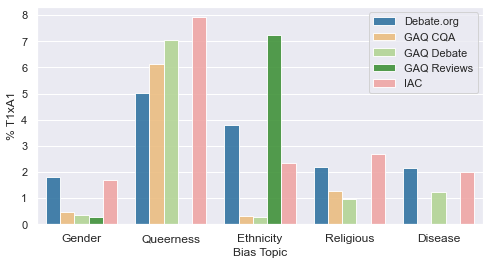

In [26]:
result_df = pd.read_csv("results_corpora_evaluation.csv")

result_df.loc[result_df['Bias Topic'] == 'Sexual Orientation', 'Bias Topic'] = 'Queerness'

result_df.loc[result_df['Dataset'] == 'IAC ConvinceMe', 'Dataset'] = 'IAC'

result_df['Dataset'].unique()

result_df = result_df[result_df['Bias Topic'] != 'Disability']

# Define the sorter
sorter = ['Gender', 'Queerness', 'Ethnicity', 'Religious', 'Disease']

result_df['Bias Topic'] = result_df['Bias Topic'].astype("category")
result_df['Bias Topic'].cat.set_categories(sorter, inplace=True, ordered=True)
result_df.sort_values('Bias Topic', inplace=True)

subset = result_df[['Dataset', 'Bias Topic', '% T1xA1']]

df_per_bias = subset.groupby(by=['Dataset', 'Bias Topic']).mean().reset_index()

# Create Color Palette
palette ={"Debate.org": "C1", 
          "GAQ CQA": "C6", 
          "IAC": "C4", 
          "GAQ Reviews": "C3",
          "GAQ Debate": "C2"
         }

sns.set_palette("Paired")
plt.figure(figsize=(8,4))
ax = sns.barplot(x="Bias Topic", y="% T1xA1", hue='Dataset', data=df_per_bias, alpha=0.9, palette=palette)


ax.set_title('')
ax.set_ylabel('% T1xA1')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
plt.legend(loc='upper right')

ax.figure.savefig('../plots/corpora_bias_evaluation.eps', format='eps', dpi=1000)